In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy.io import loadmat
import matplotlib.gridspec as gridspec
%matplotlib inline

In [110]:
data = loadmat('data/ex4data1.mat')
X = data['X']
y = data['y'].ravel()
m = X.shape[0]
n = X.shape[1]
L = 26
K = len(np.unique(y))

In [111]:
# Adding Ones 
X = np.hstack((np.ones((m, 1)), X))

In [112]:
# One hot encoding, Y of y
Y = np.zeros((m, K), dtype = 'uint8')
for i, row in enumerate(Y):
    Y[i, y[i] - 1] = 1

In [113]:
sigmoid = lambda z: 1 / (1 + np.exp(-z))

In [114]:
weights = loadmat('data/ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

nn_params = np.concatenate((theta1.flatten(), theta2.flatten()))

In [115]:
dims = K
samples = X[:, 1:][np.random.randint(m, size = dims * dims)]

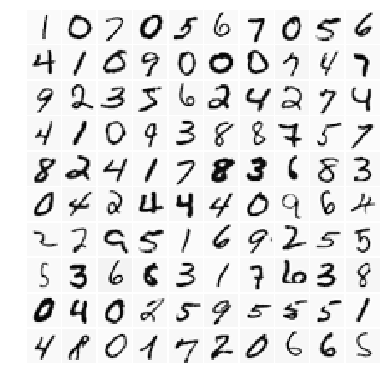

In [116]:
fig = plt.figure(figsize= (5, 5))

gs = gridspec.GridSpec(dims, dims)
gs.update(bottom = 0.01, top = 0.99, left = 0.01, right = 0.99, wspace = 0.05, hspace = 0.05)

k = 0
for i in range(dims):
    for j in range(dims):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(samples[k].reshape(int(np.sqrt(n)), int(np.sqrt(n))).T, cmap = plt.get_cmap('Greys'), interpolation = 'nearest')
        k += 1
        

In [127]:
def cost_function(parmas, X, Y, m, n, l, k):
    theta1 = parmas[:(l - 1) * (n + 1)].reshape(l - 1, n + 1)
    theta2 = parmas[(l - 1) * (n + 1):].reshape(k, l)
    a1 = X.T
    a2 = sigmoid(theta1.dot(a1))
    a2_bias = np.vstack((np.ones(m), a2))
    
    a3 = sigmoid(theta2.dot(a2_bias))
#     J = (1 / m) * (-y.dot(np.log(a3)) - (1 - y).dot(np.log(1 - a3)))
                   
#     return J
    cost = 1 / m * np.trace(- Y.dot(np.log(a3)) - (1 - Y).dot(np.log(1 - a3)))
    
    return cost

In [128]:
cost_saved = cost_function(nn_params, X, Y, m, n, L, K) 

print('Cost at parameters (loaded from ex4weights): %.6f' % cost_saved)
print('(this value should be about 0.287629)')

Cost at parameters (loaded from ex4weights): 0.287629
(this value should be about 0.287629)


In [134]:
def cost_function(parmas, X, Y, m, n, l, k, lam):
    theta1 = parmas[:(l - 1) * (n + 1)].reshape(l - 1, n + 1)
    theta2 = parmas[(l - 1) * (n + 1):].reshape(k, l)
    a1 = X.T
    a2 = sigmoid(theta1.dot(a1))
    a2_bias = np.vstack((np.ones(m), a2))
    
    a3 = sigmoid(theta2.dot(a2_bias))
    cost = 1 / m * np.trace(- Y.dot(np.log(a3)) - (1 - Y).dot(np.log(1 - a3))) \
           + (lam / (2 * m) * (np.sum(theta1[:, 1:] * theta1[:, 1:]) + np.sum(theta2[:, 1:] * theta2[:, 1:])))
    
    return cost

In [137]:
cost_saved_reg = cost_function(nn_params, X, Y, m, n, L, K, 1) 

print('Cost at parameters (loaded from ex4weights): %.6f' % cost_saved_reg)
print('(this value should be about 0.383770)')

Cost at parameters (loaded from ex4weights): 0.383770
(this value should be about 0.383770)


In [138]:
sigmoid_gradient = lambda x: sigmoid(x) * (1 - sigmoid(x))

In [139]:
print(sigmoid_gradient(np.array([-1, -0.5, 0, 0.5, 1])))

[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [142]:
eps_init = 0.12

theta_1_0 = np.random.uniform(-eps_init, eps_init, theta1.shape)
theta_2_0 = np.random.uniform(-eps_init, eps_init, theta2.shape)

nn_params_0 = np.concatenate((theta_1_0.flatten(), theta_2_0.flatten()))

In [144]:
def nn_cost_function_grad(params, X, Y, m, n, l, k, lam):
    theta1 = parmas[:(l - 1) * (n + 1)].reshape(l - 1, n + 1)
    theta2 = parmas[(l - 1) * (n + 1):].reshape(k, l)
    
    z1 = X.T
    z2 = theta1.dot(z1)
    a2_bias = np.vstack((np.ones(m), sigmoid(z2)))
    a3 = sigmoid(theta2.dot(a2_bias))
    J = 1 / m * np.trace(- Y.dot(np.log(a3)) - (1 - Y).dot(np.log(1 - a3))) \
           + (lam / (2 * m) * (np.sum(theta1[:, 1:] * theta1[:, 1:]) + np.sum(theta2[:, 1:] * theta2[:, 1:])))
    grad_theta_2 = 1 / m * (a3 - Y.T).dot(a2_bias.T)
    theta_delta = theta_2_0[:, 1:].T.dot(a3 - Y.T)
    sg_z2 = sigmoid_gradient(z2)
    grad_theta_1 = 1 / m * np.array([[np.sum(theta_delta[p] * sg_z2[p] * X.T[q]) for q in range(n + 1)] for p in range(l - 1)])
    return cost, np.concatenate((grad_theta_1.flatten(), grad_theta_2.flatten()))